In [51]:
from sklearn.datasets import make_blobs
import numpy as np
from keras.models import Sequential, Model
from keras_uncertainty.layers import StochasticDropout, SamplingSoftmax
from keras_uncertainty.models import DisentangledStochasticClassifier, StochasticClassifier
from keras.layers import Dense, Input, Dropout
from keras_uncertainty.utils import numpy_entropy


In [120]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
BATCH_SIZE = 256
NUM_SAMPLES = 100

In [129]:
def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)


def two_head_model(trunk_model, num_classes=2, num_samples=100):
    inp = Input(shape=(2,))
    x = trunk_model(inp)
    logit_mean = Dense(num_classes, activation="linear")(x)
    logit_var = Dense(num_classes, activation="softplus")(x)
    probs = SamplingSoftmax(num_samples=num_samples, variance_type="linear_std")([logit_mean, logit_var])
    
    train_model = Model(inp, probs, name="train_model")
    pred_model = Model(inp, [logit_mean, logit_var], name="pred_model")

    train_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return train_model, pred_model


def train_stochastic_model(trunk_model, x_train, y_train, epochs=300):
    train_model, pred_model = two_head_model(trunk_model)
    train_model.fit(x_train, y_train, verbose=2, epochs=epochs, batch_size=BATCH_SIZE)

    fin_model = DisentangledStochasticClassifier(pred_model, epi_num_samples=NUM_SAMPLES)

    return fin_model

def eval_disentangled_model(disentangled_model, samples):
    pred_mean, pred_ale_std, pred_epi_std = disentangled_model.predict(samples, batch_size=BATCH_SIZE)
    ale_entropy = uncertainty(pred_ale_std)
    epi_entropy = uncertainty(pred_epi_std)

    return ale_entropy, epi_entropy

def train_disentangling_dropout_model(x_train, y_train, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))

    return train_stochastic_model(model, x_train, y_train, epochs=50)

In [34]:
disentangled_dropout_model = train_disentangling_dropout_model(X, y)

Epoch 1/50
4/4 - 0s - loss: 0.7299 - accuracy: 0.5230 - 263ms/epoch - 66ms/step
Epoch 2/50
4/4 - 0s - loss: 0.6730 - accuracy: 0.5710 - 10ms/epoch - 2ms/step
Epoch 3/50
4/4 - 0s - loss: 0.6454 - accuracy: 0.6150 - 10ms/epoch - 3ms/step
Epoch 4/50
4/4 - 0s - loss: 0.6016 - accuracy: 0.6850 - 10ms/epoch - 3ms/step
Epoch 5/50
4/4 - 0s - loss: 0.5564 - accuracy: 0.7420 - 10ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.5222 - accuracy: 0.7600 - 10ms/epoch - 2ms/step
Epoch 7/50
4/4 - 0s - loss: 0.4967 - accuracy: 0.8020 - 10ms/epoch - 2ms/step
Epoch 8/50
4/4 - 0s - loss: 0.4680 - accuracy: 0.8440 - 10ms/epoch - 2ms/step
Epoch 9/50
4/4 - 0s - loss: 0.4475 - accuracy: 0.8420 - 19ms/epoch - 5ms/step
Epoch 10/50
4/4 - 0s - loss: 0.3993 - accuracy: 0.8780 - 12ms/epoch - 3ms/step
Epoch 11/50
4/4 - 0s - loss: 0.3838 - accuracy: 0.8820 - 11ms/epoch - 3ms/step
Epoch 12/50
4/4 - 0s - loss: 0.3679 - accuracy: 0.8880 - 9ms/epoch - 2ms/step
Epoch 13/50
4/4 - 0s - loss: 0.3312 - accuracy: 0.9060 - 10m

In [36]:

min_x, max_x = [-10, -10] , [10, 10]
res = 0.3

xx, yy = np.meshgrid(np.arange(min_x[0], max_x[0], res), np.arange(min_x[1], max_x[1], res))
domain = np.c_[xx.ravel(), yy.ravel()]

ale_entropy, epi_entropy = eval_disentangled_model(disentangled_dropout_model, domain)
ale_entropy = ale_entropy.reshape(xx.shape)
epi_entropy = epi_entropy.reshape(xx.shape)

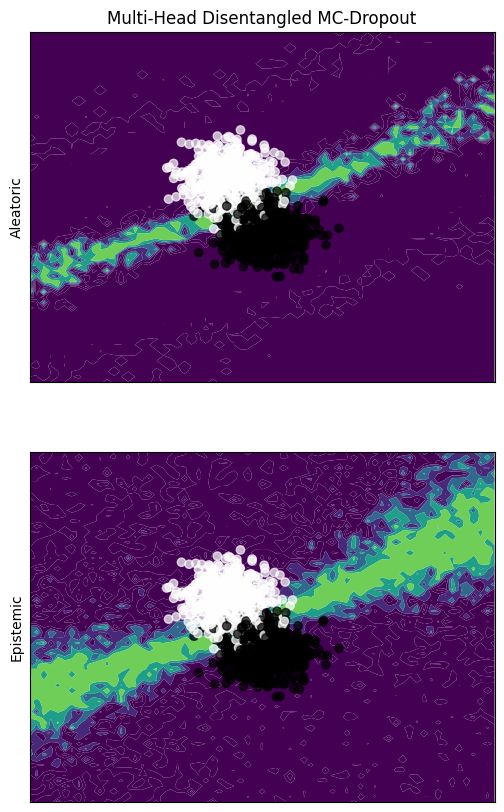

In [107]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
cmap = pl.cm.binary
my_cmap = cmap(np.arange(cmap.N))
#my_cmap[:, 0] = 0.0
my_cmap[:, -1] = 0.7
my_cmap = ListedColormap(my_cmap)


fig, axes =  plt.subplots(ncols=1, nrows=2, figsize=(6, 10), squeeze=False)    
ax_ale = axes[0][0]
ax_epi = axes[1][0]

cf_ale = ax_ale.contourf(xx, yy, ale_entropy, vmin=0.3, vmax=0.75, antialiased=True)
ax_ale.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_ale.get_xaxis().set_ticks([])
ax_ale.get_yaxis().set_ticks([])
ax_ale.autoscale(False)

cf_epi = ax_epi.contourf(xx, yy, epi_entropy, vmin=0.3, vmax=0.75, antialiased=True)
ax_epi.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_epi.get_xaxis().set_ticks([])
ax_epi.get_yaxis().set_ticks([])
ax_epi.autoscale(False)

ax_ale.set_ylabel("Aleatoric")
ax_epi.set_ylabel("Epistemic")
ax_ale.set_title("Multi-Head Disentangled MC-Dropout")

plt.show()

In [62]:
def evaluate_entropy_dropout_model(entropy_model, samples, num_samples=NUM_SAMPLES):
    preds = entropy_model.predict(samples, num_samples=num_samples)
    print(preds.shape)
    entropy = uncertainty(preds)
    
    return entropy

def train_entropy_dropout_model(x_train, y_train, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(Dropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(prob))
    model.add(Dense(2, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    model.fit(x_train, y_train, verbose=2, epochs=50)
    
    mc_model = StochasticClassifier(model)

    return mc_model


In [53]:
entropy_model = train_entropy_dropout_model(X, y)

Epoch 1/50
32/32 - 0s - loss: 0.7088 - accuracy: 0.5880 - 137ms/epoch - 4ms/step
Epoch 2/50
32/32 - 0s - loss: 0.4820 - accuracy: 0.8050 - 17ms/epoch - 540us/step
Epoch 3/50
32/32 - 0s - loss: 0.3367 - accuracy: 0.8970 - 16ms/epoch - 513us/step
Epoch 4/50
32/32 - 0s - loss: 0.2919 - accuracy: 0.8980 - 14ms/epoch - 451us/step
Epoch 5/50
32/32 - 0s - loss: 0.2385 - accuracy: 0.9140 - 15ms/epoch - 463us/step
Epoch 6/50
32/32 - 0s - loss: 0.1975 - accuracy: 0.9380 - 15ms/epoch - 455us/step
Epoch 7/50
32/32 - 0s - loss: 0.1832 - accuracy: 0.9370 - 15ms/epoch - 479us/step
Epoch 8/50
32/32 - 0s - loss: 0.1844 - accuracy: 0.9320 - 15ms/epoch - 455us/step
Epoch 9/50
32/32 - 0s - loss: 0.1777 - accuracy: 0.9390 - 14ms/epoch - 452us/step
Epoch 10/50
32/32 - 0s - loss: 0.1840 - accuracy: 0.9370 - 14ms/epoch - 440us/step
Epoch 11/50
32/32 - 0s - loss: 0.1724 - accuracy: 0.9410 - 14ms/epoch - 446us/step
Epoch 12/50
32/32 - 0s - loss: 0.1716 - accuracy: 0.9340 - 15ms/epoch - 457us/step
Epoch 13/50
32

In [121]:
individual_predictions = entropy_model.predict_samples(domain, num_samples=NUM_SAMPLES)
individual_predictions.shape

(100, 4489, 2)

In [122]:
def predictive_entropy(probs, axis=-1, eps=1e-6):
    probs = np.mean(probs, axis=0)
    return -np.sum(probs * np.log(probs + eps), axis=axis)

def shannon_entropy(probs, eps=1e-6):
  return -np.mean((probs * np.log(probs + eps)).sum(axis=-1), axis=0)

def mutual_information(probs):
  return predictive_entropy(probs) - shannon_entropy(probs)

Text(0.5, 1.0, 'Entropy disentangled MC-Dropout')

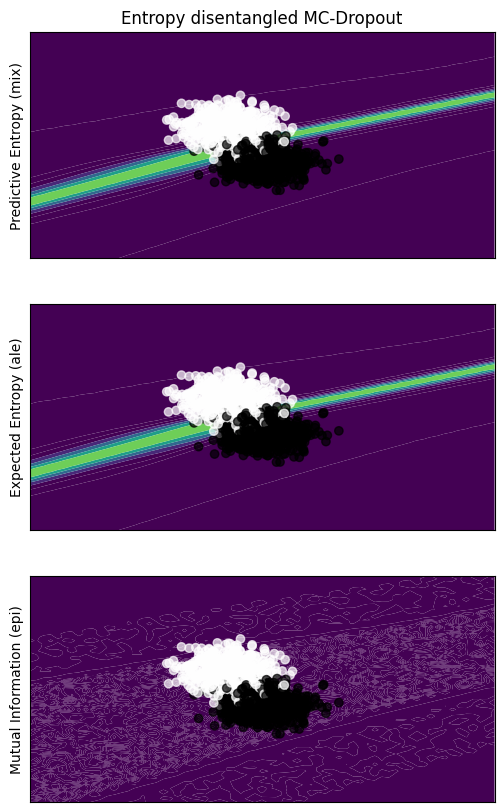

In [123]:
fig, axes =  plt.subplots(ncols=1, nrows=3, figsize=(6, 10), squeeze=False)    
ax_pred = axes[0][0]
ax_exp = axes[1][0]
ax_mi = axes[2][0]


pred_entr = predictive_entropy(individual_predictions)
pred_entr = pred_entr.reshape(xx.shape)
cf_pred = ax_pred.contourf(xx, yy, pred_entr, vmin=0.3, vmax=0.75, antialiased=True)
ax_pred.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_pred.get_xaxis().set_ticks([])
ax_pred.get_yaxis().set_ticks([])
ax_pred.autoscale(False)

exp_entr = expected_entropy(individual_predictions)
exp_entr = exp_entr.reshape(xx.shape)
cf_exp = ax_exp.contourf(xx, yy, exp_entr, vmin=0.3, vmax=0.75, antialiased=True)
ax_exp.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_exp.get_xaxis().set_ticks([])
ax_exp.get_yaxis().set_ticks([])
ax_exp.autoscale(False)


mut_inf = mutual_information(individual_predictions)
mut_inf = mut_inf.reshape(xx.shape)
cf_mi = ax_mi.contourf(xx, yy, mut_inf, vmin=0.3, vmax=0.75, antialiased=True)
ax_mi.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_mi.get_xaxis().set_ticks([])
ax_mi.get_yaxis().set_ticks([])
ax_mi.autoscale(False)


ax_pred.set_ylabel("Predictive Entropy (mix)")
ax_exp.set_ylabel("Expected Entropy (ale)")
ax_mi.set_ylabel("Mutual Information (epi)")

ax_pred.set_title("Entropy disentangled MC-Dropout")

In [174]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

disentangling_accuracies = []
disentangling_aleatorics = []
disentangling_epistemics = []

entropy_accuracies = []
entropy_aleatorics = []
entropy_epistemics = []
X_test, y_test = make_blobs(n_samples=500, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
dataset_sizes = np.logspace(start=1, stop=10, base=2, num=20) 

for dataset_size in tqdm(dataset_sizes):

    X_train, y_train = make_blobs(n_samples=int(dataset_size), n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
    
    
    disentangle_model = train_disentangling_dropout_model(X_train, y_train)
    entropy_model = train_entropy_dropout_model(X_train, y_train)

    pred_mean, pred_ale_std, pred_epi_std = disentangle_model.predict(X_test, batch_size=BATCH_SIZE)
    entropy_preds = entropy_model.predict_samples(X_test, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
    disentangling_accuracies.append(accuracy_score(y_test, pred_mean.argmax(axis=1)))
    disentangling_aleatorics.append(uncertainty(pred_ale_std).mean())
    disentangling_epistemics.append(uncertainty(pred_epi_std).mean())

    entropy_accuracies.append(accuracy_score(y_test, entropy_preds.mean(axis=0).argmax(axis=1)))
    entropy_aleatorics.append(expected_entropy(entropy_preds).mean())
    entropy_epistemics.append(mutual_information(entropy_preds).mean())


  0%|                                                                                                                                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

Epoch 1/50
1/1 - 0s - loss: 0.9072 - accuracy: 0.5000 - 254ms/epoch - 254ms/step
Epoch 2/50
1/1 - 0s - loss: 0.5962 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8616 - accuracy: 0.0000e+00 - 1ms/epoch - 1ms/step
Epoch 4/50
1/1 - 0s - loss: 0.9335 - accuracy: 0.0000e+00 - 1ms/epoch - 1ms/step
Epoch 5/50
1/1 - 0s - loss: 1.5233 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 1.1865 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7531 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.8014 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 1.2380 - accuracy: 0.0000e+00 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 1.0162 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6643 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 1.3296 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.8660 - accuracy: 0.0000e+0

  5%|█████████████▊                                                                                                                                                                                                                                                                      | 1/20 [00:41<13:06, 41.41s/it]

Epoch 1/50
1/1 - 0s - loss: 0.7584 - accuracy: 0.5000 - 252ms/epoch - 252ms/step
Epoch 2/50
1/1 - 0s - loss: 0.6784 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6429 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7169 - accuracy: 0.5000 - 1ms/epoch - 1ms/step
Epoch 5/50
1/1 - 0s - loss: 0.8571 - accuracy: 0.0000e+00 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7113 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7870 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7109 - accuracy: 0.5000 - 1ms/epoch - 1ms/step
Epoch 9/50
1/1 - 0s - loss: 0.5551 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.5019 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6026 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.5781 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.6927 - accuracy: 0.5000 - 2ms/epoc

 10%|███████████████████████████▌                                                                                                                                                                                                                                                        | 2/20 [01:24<12:40, 42.25s/it]

Epoch 1/50
1/1 - 0s - loss: 0.9740 - accuracy: 0.3333 - 259ms/epoch - 259ms/step
Epoch 2/50
1/1 - 0s - loss: 0.6568 - accuracy: 0.6667 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.9154 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5594 - accuracy: 0.6667 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4763 - accuracy: 0.6667 - 1ms/epoch - 1ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4516 - accuracy: 1.0000 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.8099 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6791 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.5917 - accuracy: 0.6667 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.6861 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6310 - accuracy: 0.6667 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.7518 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.5467 - accuracy: 1.0000 - 2ms/epoch - 

 15%|█████████████████████████████████████████▍                                                                                                                                                                                                                                          | 3/20 [02:06<11:56, 42.12s/it]

Epoch 1/50
1/1 - 0s - loss: 0.8083 - accuracy: 0.2000 - 250ms/epoch - 250ms/step
Epoch 2/50
1/1 - 0s - loss: 0.8120 - accuracy: 0.2000 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5526 - accuracy: 0.8000 - 1ms/epoch - 1ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7095 - accuracy: 0.4000 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7681 - accuracy: 0.2000 - 1ms/epoch - 1ms/step
Epoch 6/50
1/1 - 0s - loss: 1.1130 - accuracy: 0.4000 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6882 - accuracy: 0.6000 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.8718 - accuracy: 0.6000 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.9012 - accuracy: 0.2000 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.5502 - accuracy: 0.6000 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.5793 - accuracy: 0.8000 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.7125 - accuracy: 0.8000 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.4403 - accuracy: 1.0000 - 2ms/epoch - 

 20%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 4/20 [02:47<11:09, 41.82s/it]

Epoch 1/50
1/1 - 0s - loss: 0.8732 - accuracy: 0.1429 - 255ms/epoch - 255ms/step
Epoch 2/50
1/1 - 0s - loss: 1.1241 - accuracy: 0.0000e+00 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.9522 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8397 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.9325 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.9951 - accuracy: 0.1429 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 1.0958 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7068 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.9108 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.9808 - accuracy: 0.1429 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6900 - accuracy: 0.4286 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.7962 - accuracy: 0.4286 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 1.0282 - accuracy: 0.1429 - 2ms/epoc

 25%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 5/20 [03:28<10:24, 41.62s/it]

Epoch 1/50
1/1 - 0s - loss: 1.3733 - accuracy: 0.3000 - 254ms/epoch - 254ms/step
Epoch 2/50
1/1 - 0s - loss: 1.4825 - accuracy: 0.3000 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 1.3157 - accuracy: 0.3000 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0584 - accuracy: 0.4000 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 1.2198 - accuracy: 0.1000 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 1.1052 - accuracy: 0.3000 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 1.2716 - accuracy: 0.6000 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 1.1493 - accuracy: 0.4000 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 1.5435 - accuracy: 0.4000 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.7325 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 1.4562 - accuracy: 0.4000 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.9241 - accuracy: 0.3000 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.7180 - accuracy: 0.5000 - 2ms/epoch - 

 30%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 6/20 [04:10<09:41, 41.55s/it]

Epoch 1/50
1/1 - 0s - loss: 1.0021 - accuracy: 0.4286 - 248ms/epoch - 248ms/step
Epoch 2/50
1/1 - 0s - loss: 0.6938 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5728 - accuracy: 0.7857 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.6959 - accuracy: 0.7143 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5671 - accuracy: 0.7857 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6729 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7017 - accuracy: 0.5714 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7047 - accuracy: 0.5714 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6656 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.7901 - accuracy: 0.5714 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.5371 - accuracy: 0.9286 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.5793 - accuracy: 0.7143 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.5626 - accuracy: 0.7857 - 2ms/epoch - 

 35%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 7/20 [04:51<09:00, 41.58s/it]

Epoch 1/50
1/1 - 0s - loss: 0.7243 - accuracy: 0.5789 - 271ms/epoch - 271ms/step
Epoch 2/50
1/1 - 0s - loss: 0.7144 - accuracy: 0.5263 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8824 - accuracy: 0.3158 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7322 - accuracy: 0.3158 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.8048 - accuracy: 0.4211 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7911 - accuracy: 0.4211 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5916 - accuracy: 0.6842 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6432 - accuracy: 0.4737 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6362 - accuracy: 0.6316 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.7966 - accuracy: 0.4211 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6825 - accuracy: 0.6316 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.6075 - accuracy: 0.6842 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.7149 - accuracy: 0.5789 - 2ms/epoch - 

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 8/20 [05:33<08:18, 41.52s/it]

Epoch 1/50
1/1 - 0s - loss: 0.9599 - accuracy: 0.2963 - 249ms/epoch - 249ms/step
Epoch 2/50
1/1 - 0s - loss: 0.8411 - accuracy: 0.4074 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 1.0890 - accuracy: 0.4444 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 1.2367 - accuracy: 0.2963 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.8994 - accuracy: 0.4444 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7863 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 1.1277 - accuracy: 0.3704 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 1.0889 - accuracy: 0.4444 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.9238 - accuracy: 0.4444 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.7470 - accuracy: 0.5926 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 1.0155 - accuracy: 0.4074 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.7964 - accuracy: 0.4444 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.9966 - accuracy: 0.2963 - 2ms/epoch - 

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 9/20 [06:14<07:36, 41.48s/it]

Epoch 1/50
1/1 - 0s - loss: 0.8633 - accuracy: 0.3947 - 249ms/epoch - 249ms/step
Epoch 2/50
1/1 - 0s - loss: 0.8612 - accuracy: 0.3684 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.7440 - accuracy: 0.4211 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8346 - accuracy: 0.3684 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7996 - accuracy: 0.5263 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.8808 - accuracy: 0.4211 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7230 - accuracy: 0.5526 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7260 - accuracy: 0.5526 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.7226 - accuracy: 0.4474 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.7098 - accuracy: 0.4474 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6947 - accuracy: 0.5263 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.6711 - accuracy: 0.5526 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.7443 - accuracy: 0.5000 - 2ms/epoch - 

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 10/20 [06:55<06:53, 41.35s/it]

Epoch 1/50
1/1 - 0s - loss: 0.6534 - accuracy: 0.5283 - 253ms/epoch - 253ms/step
Epoch 2/50
1/1 - 0s - loss: 0.6031 - accuracy: 0.6415 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6098 - accuracy: 0.6038 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5823 - accuracy: 0.6792 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5588 - accuracy: 0.6226 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6998 - accuracy: 0.6226 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6679 - accuracy: 0.5660 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6160 - accuracy: 0.6792 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6846 - accuracy: 0.5660 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.5524 - accuracy: 0.7170 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.5232 - accuracy: 0.7547 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.5639 - accuracy: 0.7170 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.5487 - accuracy: 0.7736 - 2ms/epoch - 

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 11/20 [07:37<06:14, 41.56s/it]

Epoch 1/50
1/1 - 0s - loss: 0.8294 - accuracy: 0.4189 - 253ms/epoch - 253ms/step
Epoch 2/50
1/1 - 0s - loss: 0.8358 - accuracy: 0.3108 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8481 - accuracy: 0.4054 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8670 - accuracy: 0.3378 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.9167 - accuracy: 0.3784 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7663 - accuracy: 0.4324 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.8072 - accuracy: 0.4189 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7698 - accuracy: 0.3514 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.8203 - accuracy: 0.4189 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.7656 - accuracy: 0.4189 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.7409 - accuracy: 0.5270 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.6946 - accuracy: 0.5676 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.7372 - accuracy: 0.5405 - 2ms/epoch - 

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 12/20 [08:19<05:32, 41.56s/it]

Epoch 1/50
1/1 - 0s - loss: 0.9201 - accuracy: 0.3725 - 251ms/epoch - 251ms/step
Epoch 2/50
1/1 - 0s - loss: 0.9228 - accuracy: 0.4216 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8420 - accuracy: 0.4216 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8436 - accuracy: 0.4020 - 2ms/epoch - 2ms/step
Epoch 5/50
1/1 - 0s - loss: 0.8146 - accuracy: 0.4706 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7844 - accuracy: 0.4510 - 2ms/epoch - 2ms/step
Epoch 7/50
1/1 - 0s - loss: 0.8592 - accuracy: 0.3529 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.7336 - accuracy: 0.5000 - 2ms/epoch - 2ms/step
Epoch 9/50
1/1 - 0s - loss: 0.7254 - accuracy: 0.5686 - 2ms/epoch - 2ms/step
Epoch 10/50
1/1 - 0s - loss: 0.6875 - accuracy: 0.5196 - 2ms/epoch - 2ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6709 - accuracy: 0.5980 - 2ms/epoch - 2ms/step
Epoch 12/50
1/1 - 0s - loss: 0.7398 - accuracy: 0.5392 - 2ms/epoch - 2ms/step
Epoch 13/50
1/1 - 0s - loss: 0.6913 - accuracy: 0.5392 - 2ms/epoch - 

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 13/20 [09:00<04:50, 41.55s/it]

Epoch 1/50
1/1 - 0s - loss: 0.7505 - accuracy: 0.5493 - 252ms/epoch - 252ms/step
Epoch 2/50
1/1 - 0s - loss: 0.7210 - accuracy: 0.5845 - 2ms/epoch - 2ms/step
Epoch 3/50
1/1 - 0s - loss: 0.7201 - accuracy: 0.5845 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7341 - accuracy: 0.5211 - 3ms/epoch - 3ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7661 - accuracy: 0.5563 - 2ms/epoch - 2ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6366 - accuracy: 0.6479 - 3ms/epoch - 3ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6164 - accuracy: 0.7183 - 2ms/epoch - 2ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6645 - accuracy: 0.6338 - 5ms/epoch - 5ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6465 - accuracy: 0.6972 - 13ms/epoch - 13ms/step
Epoch 10/50
1/1 - 0s - loss: 0.5856 - accuracy: 0.7465 - 12ms/epoch - 12ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6139 - accuracy: 0.7113 - 5ms/epoch - 5ms/step
Epoch 12/50
1/1 - 0s - loss: 0.6403 - accuracy: 0.6761 - 4ms/epoch - 4ms/step
Epoch 13/50
1/1 - 0s - loss: 0.6329 - accuracy: 0.6549 - 3ms/epoc

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 14/20 [09:42<04:09, 41.64s/it]

Epoch 1/50
1/1 - 0s - loss: 0.7836 - accuracy: 0.4697 - 251ms/epoch - 251ms/step
Epoch 2/50
1/1 - 0s - loss: 0.7933 - accuracy: 0.3939 - 3ms/epoch - 3ms/step
Epoch 3/50
1/1 - 0s - loss: 0.7597 - accuracy: 0.4394 - 2ms/epoch - 2ms/step
Epoch 4/50
1/1 - 0s - loss: 0.6999 - accuracy: 0.5303 - 3ms/epoch - 3ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7036 - accuracy: 0.5354 - 3ms/epoch - 3ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7017 - accuracy: 0.5152 - 3ms/epoch - 3ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6909 - accuracy: 0.5859 - 3ms/epoch - 3ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6742 - accuracy: 0.5303 - 3ms/epoch - 3ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6625 - accuracy: 0.5303 - 3ms/epoch - 3ms/step
Epoch 10/50
1/1 - 0s - loss: 0.6476 - accuracy: 0.5707 - 3ms/epoch - 3ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6472 - accuracy: 0.6263 - 3ms/epoch - 3ms/step
Epoch 12/50
1/1 - 0s - loss: 0.6285 - accuracy: 0.5556 - 3ms/epoch - 3ms/step
Epoch 13/50
1/1 - 0s - loss: 0.6367 - accuracy: 0.5909 - 3ms/epoch - 

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 15/20 [10:24<03:28, 41.70s/it]

Epoch 1/50
2/2 - 0s - loss: 0.8534 - accuracy: 0.3818 - 257ms/epoch - 129ms/step
Epoch 2/50
2/2 - 0s - loss: 0.7869 - accuracy: 0.4764 - 4ms/epoch - 2ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7641 - accuracy: 0.4945 - 4ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7117 - accuracy: 0.5236 - 4ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.7362 - accuracy: 0.4945 - 4ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.6941 - accuracy: 0.5382 - 4ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.6542 - accuracy: 0.6073 - 4ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.6870 - accuracy: 0.5382 - 4ms/epoch - 2ms/step
Epoch 9/50
2/2 - 0s - loss: 0.6265 - accuracy: 0.6109 - 4ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.6277 - accuracy: 0.6436 - 4ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.5900 - accuracy: 0.6945 - 4ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.6248 - accuracy: 0.6182 - 4ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.5841 - accuracy: 0.6909 - 4ms/epoch - 

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 16/20 [11:10<02:52, 43.02s/it]

Epoch 1/50
2/2 - 0s - loss: 0.7733 - accuracy: 0.4555 - 252ms/epoch - 126ms/step
Epoch 2/50
2/2 - 0s - loss: 0.7971 - accuracy: 0.4267 - 4ms/epoch - 2ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7113 - accuracy: 0.5000 - 4ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.6803 - accuracy: 0.5681 - 4ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.6950 - accuracy: 0.5916 - 4ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.6513 - accuracy: 0.6230 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.6439 - accuracy: 0.6178 - 4ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.6025 - accuracy: 0.6780 - 5ms/epoch - 2ms/step
Epoch 9/50
2/2 - 0s - loss: 0.5676 - accuracy: 0.7042 - 5ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.5401 - accuracy: 0.7958 - 5ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.5482 - accuracy: 0.7408 - 5ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.5038 - accuracy: 0.8010 - 5ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.4957 - accuracy: 0.7775 - 5ms/epoch - 

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 17/20 [11:52<02:08, 42.67s/it]

Epoch 1/50
3/3 - 0s - loss: 0.6823 - accuracy: 0.5763 - 261ms/epoch - 87ms/step
Epoch 2/50
3/3 - 0s - loss: 0.6699 - accuracy: 0.5857 - 6ms/epoch - 2ms/step
Epoch 3/50
3/3 - 0s - loss: 0.6070 - accuracy: 0.6855 - 7ms/epoch - 2ms/step
Epoch 4/50
3/3 - 0s - loss: 0.5795 - accuracy: 0.7024 - 6ms/epoch - 2ms/step
Epoch 5/50
3/3 - 0s - loss: 0.5327 - accuracy: 0.7571 - 6ms/epoch - 2ms/step
Epoch 6/50
3/3 - 0s - loss: 0.5304 - accuracy: 0.7420 - 6ms/epoch - 2ms/step
Epoch 7/50
3/3 - 0s - loss: 0.4952 - accuracy: 0.7910 - 6ms/epoch - 2ms/step
Epoch 8/50
3/3 - 0s - loss: 0.4659 - accuracy: 0.8154 - 6ms/epoch - 2ms/step
Epoch 9/50
3/3 - 0s - loss: 0.4611 - accuracy: 0.8041 - 6ms/epoch - 2ms/step
Epoch 10/50
3/3 - 0s - loss: 0.4312 - accuracy: 0.8362 - 6ms/epoch - 2ms/step
Epoch 11/50
3/3 - 0s - loss: 0.4247 - accuracy: 0.8399 - 6ms/epoch - 2ms/step
Epoch 12/50
3/3 - 0s - loss: 0.4002 - accuracy: 0.8380 - 6ms/epoch - 2ms/step
Epoch 13/50
3/3 - 0s - loss: 0.3845 - accuracy: 0.8663 - 6ms/epoch - 2

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 18/20 [12:34<01:24, 42.50s/it]

Epoch 1/50
3/3 - 0s - loss: 0.6934 - accuracy: 0.5631 - 255ms/epoch - 85ms/step
Epoch 2/50
3/3 - 0s - loss: 0.7007 - accuracy: 0.5115 - 7ms/epoch - 2ms/step
Epoch 3/50
3/3 - 0s - loss: 0.6560 - accuracy: 0.5848 - 7ms/epoch - 2ms/step
Epoch 4/50
3/3 - 0s - loss: 0.6138 - accuracy: 0.6364 - 7ms/epoch - 2ms/step
Epoch 5/50
3/3 - 0s - loss: 0.6010 - accuracy: 0.6567 - 7ms/epoch - 2ms/step
Epoch 6/50
3/3 - 0s - loss: 0.5905 - accuracy: 0.6730 - 7ms/epoch - 2ms/step
Epoch 7/50
3/3 - 0s - loss: 0.5528 - accuracy: 0.7137 - 7ms/epoch - 2ms/step
Epoch 8/50
3/3 - 0s - loss: 0.5368 - accuracy: 0.7205 - 7ms/epoch - 2ms/step
Epoch 9/50
3/3 - 0s - loss: 0.5139 - accuracy: 0.7693 - 7ms/epoch - 2ms/step
Epoch 10/50
3/3 - 0s - loss: 0.4920 - accuracy: 0.8005 - 7ms/epoch - 2ms/step
Epoch 11/50
3/3 - 0s - loss: 0.4661 - accuracy: 0.8304 - 7ms/epoch - 2ms/step
Epoch 12/50
3/3 - 0s - loss: 0.4499 - accuracy: 0.8223 - 7ms/epoch - 2ms/step
Epoch 13/50
3/3 - 0s - loss: 0.4255 - accuracy: 0.8765 - 7ms/epoch - 2

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 19/20 [13:16<00:42, 42.33s/it]

Epoch 1/50
4/4 - 0s - loss: 0.7240 - accuracy: 0.5244 - 259ms/epoch - 65ms/step
Epoch 2/50
4/4 - 0s - loss: 0.6716 - accuracy: 0.5986 - 9ms/epoch - 2ms/step
Epoch 3/50
4/4 - 0s - loss: 0.6204 - accuracy: 0.6328 - 9ms/epoch - 2ms/step
Epoch 4/50
4/4 - 0s - loss: 0.5853 - accuracy: 0.6631 - 9ms/epoch - 2ms/step
Epoch 5/50
4/4 - 0s - loss: 0.5537 - accuracy: 0.6895 - 9ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.5080 - accuracy: 0.7539 - 10ms/epoch - 2ms/step
Epoch 7/50
4/4 - 0s - loss: 0.4677 - accuracy: 0.7803 - 9ms/epoch - 2ms/step
Epoch 8/50
4/4 - 0s - loss: 0.4513 - accuracy: 0.8008 - 9ms/epoch - 2ms/step
Epoch 9/50
4/4 - 0s - loss: 0.4153 - accuracy: 0.8447 - 9ms/epoch - 2ms/step
Epoch 10/50
4/4 - 0s - loss: 0.3973 - accuracy: 0.8535 - 9ms/epoch - 2ms/step
Epoch 11/50
4/4 - 0s - loss: 0.3704 - accuracy: 0.8604 - 9ms/epoch - 2ms/step
Epoch 12/50
4/4 - 0s - loss: 0.3481 - accuracy: 0.8750 - 9ms/epoch - 2ms/step
Epoch 13/50
4/4 - 0s - loss: 0.3217 - accuracy: 0.9033 - 9ms/epoch - 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:59<00:00, 41.96s/it]


In [168]:
dataset_size

2.21221629107045e+38

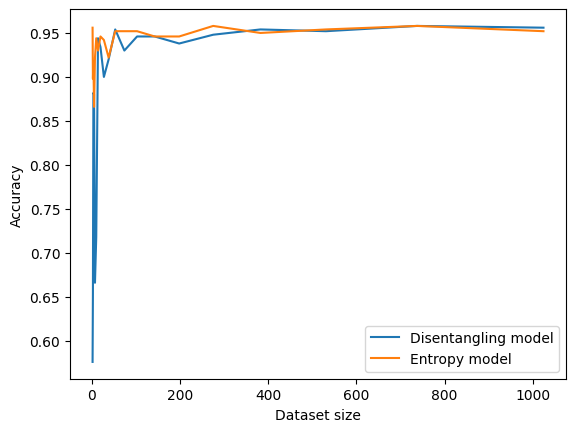

In [183]:

dataset_sizes = np.logspace(start=1, stop=10, base=2, num=20) 

plt.plot(dataset_sizes, disentangling_accuracies, label="Disentangling model")
plt.plot(dataset_sizes, entropy_accuracies, label="Entropy model")
plt.ylabel("Accuracy")
plt.xlabel("Dataset size")
plt.legend()
plt.show()


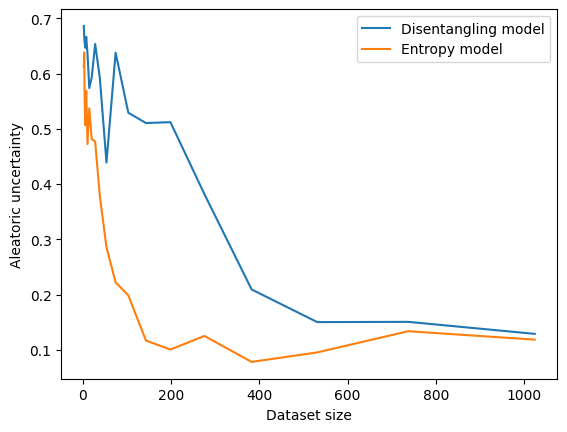

In [184]:

plt.plot(dataset_sizes, disentangling_aleatorics, label="Disentangling model")
plt.plot(dataset_sizes, entropy_aleatorics, label="Entropy model")
plt.ylabel("Aleatoric uncertainty")
plt.xlabel("Dataset size")
plt.legend()
plt.show()


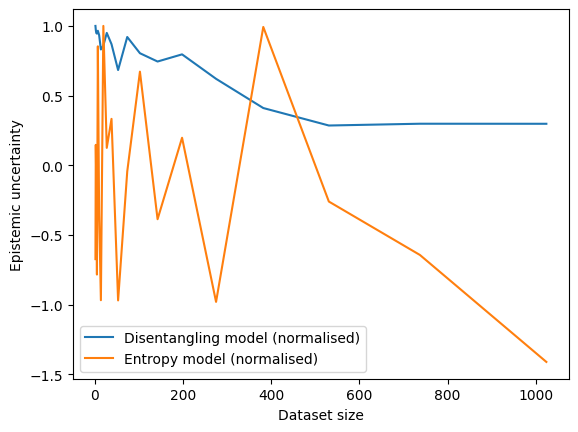

In [187]:

plt.plot(dataset_sizes, disentangling_epistemics / max(disentangling_epistemics), label="Disentangling model (normalised)")
plt.plot(dataset_sizes, entropy_epistemics / max(entropy_epistemics), label="Entropy model (normalised)")
plt.ylabel("Epistemic uncertainty")
plt.xlabel("Dataset size")
plt.legend()
plt.show()


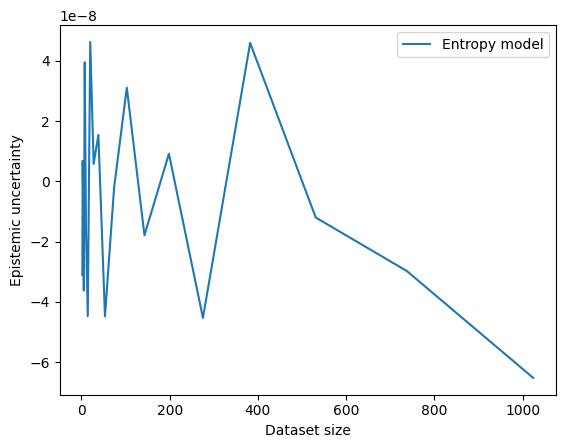

In [186]:

# plt.plot(dataset_sizes, disentangling_epistemics, label="Disentangling model")
plt.plot(dataset_sizes, entropy_epistemics, label="Entropy model")
plt.ylabel("Epistemic uncertainty")
plt.xlabel("Dataset size")
plt.legend()
plt.show()

Text(0.5, 0, 'Dataset size')

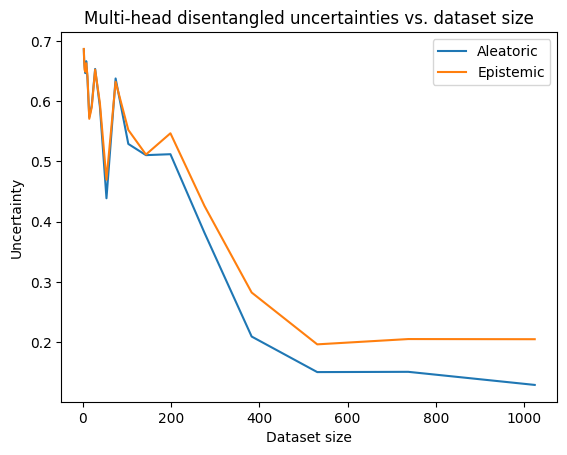

In [191]:
plt.plot(dataset_sizes, disentangling_aleatorics, label="Aleatoric")
plt.plot(dataset_sizes, disentangling_epistemics, label="Epistemic")
plt.title("Multi-head disentangled uncertainties vs. dataset size")
plt.legend()
plt.ylabel("Uncertainty")
plt.xlabel("Dataset size")


Text(0.5, 0, 'Dataset size')

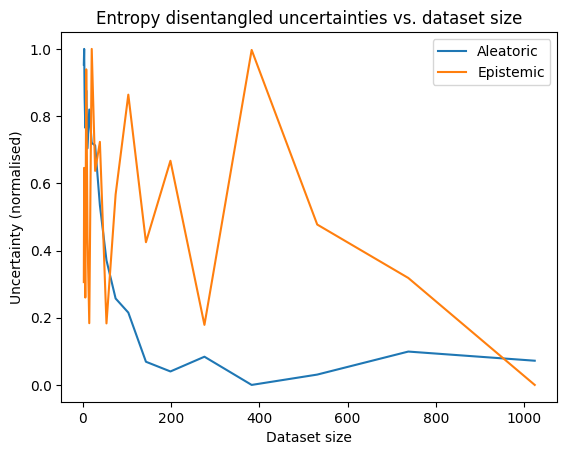

In [207]:
plt.plot(dataset_sizes, (entropy_aleatorics - min(entropy_aleatorics)) / max(entropy_aleatorics - min(entropy_aleatorics)), label="Aleatoric")
plt.plot(dataset_sizes, (entropy_epistemics - min(entropy_epistemics)) / max(entropy_epistemics -min(entropy_epistemics) ), label="Epistemic")
plt.title("Entropy disentangled uncertainties vs. dataset size")
plt.legend()
plt.ylabel("Uncertainty (normalised)")
plt.xlabel("Dataset size")


In [203]:
(entropy_aleatorics - min(entropy_aleatorics)) / max(entropy_aleatorics)

array([0.83657175, 0.8776921 , 0.7497864 , 0.6715637 , 0.7692108 ,
       0.61818737, 0.71939504, 0.632057  , 0.6256656 , 0.46942997,
       0.3256086 , 0.22577107, 0.18893681, 0.06052912, 0.03517873,
       0.07365996, 0.        , 0.02700019, 0.08712885, 0.06322219],
      dtype=float32)